### They are all equally spaced

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation
import os

In [25]:
save_path = r'C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

SyntaxError: unterminated string literal (detected at line 1) (1966478977.py, line 1)

In [35]:
########################################                 Define constants                   #############################################
N = 2

g_0      = -0.5
g_max    = 1
g_size   = 100

x_0      = 0.2
x_max    = 0.6
x_size   = 50

phi_0    = 0
phi_max  = 2 * np.pi / 3
phi_size = 100 # must be even

t_max    = 40
t_size   = 100

fixed_dist  = 1
fixed_d_hat = np.array([1, 1]) / np.sqrt(2)
fixed_gamma = 1
fixed_dist  = 1

########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma
phis   = np.linspace(phi_0, phi_max, phi_size)
dists  = np.linspace(x_0, x_max, x_size)
gammas = np.linspace(g_0, g_max, x_size)

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.0000000e+00  1.2246468e-16  0.0000000e+00]]


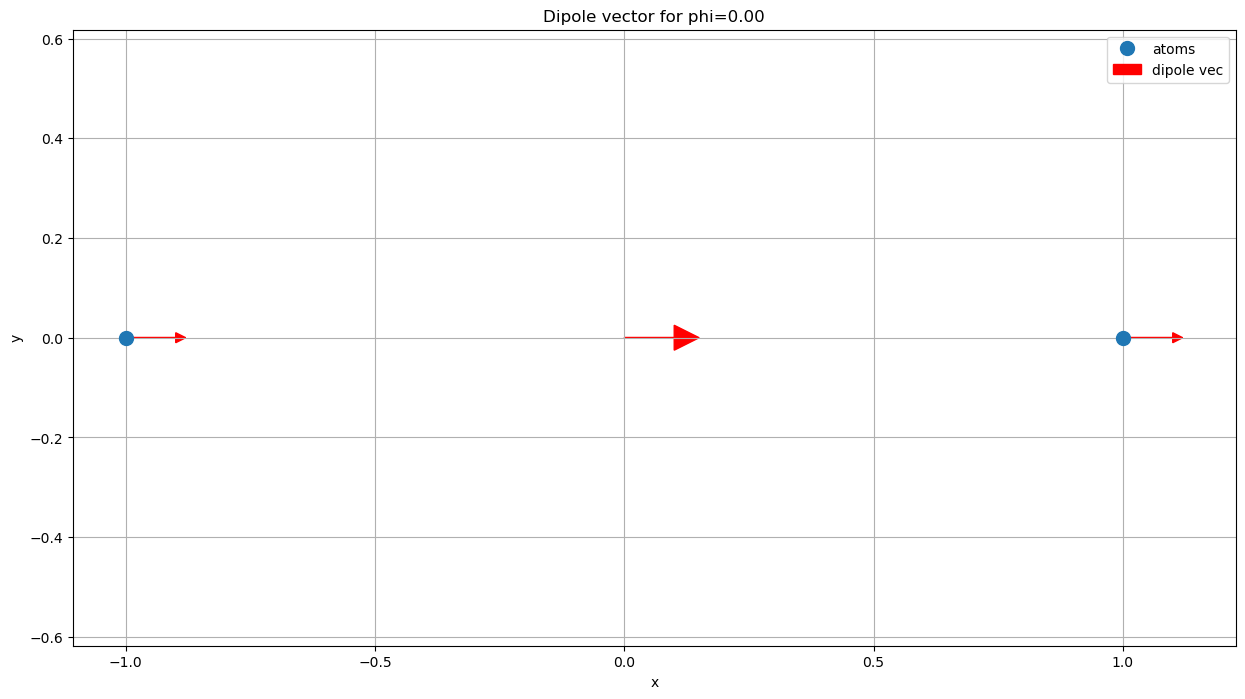

In [37]:
########################################               define the geometry                 #############################################
def dipole_vector(phi: float):
    """Returns the dipole vector given its magnitude and direction angle phi."""
    phi = np.array([np.cos(phi), np.sin(phi), 0])
    return (phi / np.linalg.norm(phi))
d_hats = np.array([dipole_vector(phi) for phi in phis])

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

def atom_positions(distance = fixed_dist, 
              N = N):
    Pos = np.zeros((N, 3))

    mu = 2 * np.pi / N
    radius = distance / 2 / np.sin(np.pi / N)
    helper = np.array([radius, 0, 0])
    for i in range(N):
        rotation_matrix = np.linalg.matrix_power(z_rotation(mu), i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    
    return Pos

positions = atom_positions(N)
print(positions)

# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
fig, ax = plt.subplots(figsize=(15, 8))
def update(frame):
    ax.clear()
    d_hat = d_hats[frame]
    ax.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
    ax.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
             head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
    for i, position in enumerate(positions):
        ax.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
                 head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend()
    ax.axis('equal')
    ax.set_title(f'Dipole vector for phi={phis[frame]:.2f}')

# Create the animation
ani = FuncAnimation(fig, update, frames=phi_size, repeat=False)
#ani.save(save_path + f'/N={N}_dipole_vector_movement.gif', writer='pillow', fps=10)
#plt.show()

In [2]:
########################################             create the Hamiltonean                 #################################################
#jetzt direkter weg zur NxN matrix
def H_eff(N: int,
          distance: float = fixed_dist, 
          d_hat: np.array = fixed_d_hat,
          gamma: float = fixed_gamma):

    H_eff_matrix = np.zeros((N, N), dtype=complex)
    pos = atom_positions(N, distance)

    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))

            matrix_element = V_ij - 1j * 0.5 * Gamma_ij
            H_eff_matrix[i, j] = matrix_element
            
#            self._Gamma = matrix_element.imag  ???????
    return Qobj(H_eff_matrix)
H_ex = H_eff(N)
H_ex

NameError: name 'fixed_dist' is not defined

In [1]:
def calc_norm(times: np.array,
              distance = fixed_dist,
              gamma    = fixed_gamma,
              d_hat    = fixed_d_hat,
              Psi_0    = basis(N, 0)):
    '''          works for NxN ^ matrices
    Calculate the probability of transitioning from an initial state to a final state     over a given time, given the parameters of the Hamiltonian.    '''
    H = H_eff_red(N, distance, d_hat, gamma)
    all_norms = []
    for t in times:
        U = (-1j * H * t).expm()
        Psi_t = U * Psi_0
        norm_sq = Psi_t.norm()**2
        all_norms.append(norm_sq)
    return np.array(all_norms)

def Norms(times: np.array,
          distances = np.array([fixed_dist]),
          gammas    = np.array([fixed_gamma]),
          d_hats    = np.array([fixed_d_hat]),
          Psi_0     = basis(N, 0),
          animate_dist = False, animate_dipole = False, animate_gamma = False): # only one at a time
    ''' works for NxN   ^ matrices '''    
    norms = np.zeros((len(gammas), len(distances), len(d_hats), len(times)), dtype=float)
    filename_prefix = ''
    
    if animate_dist:
        for c_idx, dist in enumerate(tqdm(distances, desc='Coefficients')):
            for d_idx, d_hat in enumerate(d_hats):
                for g_idx, gamma in enumerate(gammas):
                    norms[g_idx, c_idx, d_idx, :] = calc_norm(times, distance=dist, gamma=gamma, d_hat=d_hat, Psi_0=Psi_0)

        for g_idx, gamma in enumerate(gammas):
            for d_idx, d_hat in enumerate(d_hats):
                filename_prefix = f'Ps_g={gamma:.2f}_dipole=[{d_hat[0]:.2f},{d_hat[1]:.2f}]'
                DIST_ani(norms[g_idx, :, d_idx, :], filename_prefix, distances)
        
    if animate_dipole:
        for d_idx, d_hat in enumerate(tqdm(d_hats, desc='Dipoles')):
            for c_idx, dist in enumerate(distances):
                for g_idx, gamma in enumerate(gammas):
                    norms[g_idx, c_idx, d_idx, :] = calc_norm(times, distance=dist, gamma=gamma, d_hat=d_hat, Psi_0=Psi_0)
    
    if animate_gamma:
        for g_idx, gamma in enumerate(tqdm(gammas, desc='Gammas')):
            for d_idx, d_hat in enumerate(d_hats):
                for c_idx, dist in enumerate(distances):
                    norms[g_idx, c_idx, d_idx, :] = calc_norm(times, distance=dist, gamma=gamma, d_hat=d_hat, Psi_0=Psi_0)

    return norms, filename_prefix
    
#            progress_bar = tqdm(times, desc=f"Calculating norms for d_hat index={i}, x={x:.2f}", unit="timestep", leave=False)

NameError: name 'fixed_dist' is not defined

In [8]:
def DIST_ani(data, filename_prefix, distances):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    def update(frame):
        ax.clear()
        ax.set_title(f'Distance = {distances[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Distance = {distances[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()
    
    ani = FuncAnimation(fig, update, frames=len(distances), interval=200)
    ani.save(save_path + f'\DistDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

def DIPOLE_ani(data, filename_prefix, dipoles):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f'Dipole = {dipoles[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Dipole = {dipoles[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(dipoles), interval=200)
    ani.save(save_path + f'\DipoleDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

def GAMMA_ani(data, filename_prefix, gammas):
    fig, ax = plt.subplots(figsize=(8, 6))

    def update(frame):
        ax.clear()
        ax.set_title(f'Gamma = {gammas[frame]:.2f}')
        ax.set_xlabel("Time t")
        ax.set_ylabel(r'$P_{sur}$')
        ax.plot(times, data[frame], label=f'Gamma = {gammas[frame]:.2f}')
        ax.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(gammas), interval=200)
    ani.save(save_path + f'\GammaDep/{filename_prefix}.gif', writer='pillow', fps=10)
    plt.close(fig)

In [9]:
#############################################---------        calculations           ---------###########################################################

In [10]:
################ TRY to get the Wave-packet
gamma=1
# Annahmen über N und a
d = 0.234 * gamma
k_s = np.pi
sigma = 0.103 * k_s
wp_sh = 1 / 4

kd_range = np.arange(0, N) * 2 * np.pi / N

def calc_T() -> np.ndarray:

    T_temp = np.zeros((N, N), dtype=complex)
    for i in range(kd_range.size):
        T_temp[:, i] = np.exp(1j * np.arange(0, N) * kd_range[i])

    return 1 / np.sqrt(N) * T_temp

def psi0_reziprokal_ps():
    gaussian_state_rs = np.exp(-(kd_range - k_s) ** 2 / (4 * sigma ** 2))
    gaussian_state_rs = gaussian_state_rs / np.sqrt(np.vdot(gaussian_state_rs, gaussian_state_rs))
    wp_shift = np.exp(-2j * wp_sh * np.pi * np.arange(N))
    psi0 = np.matmul(calc_T(), wp_shift * gaussian_state_rs)

    return Qobj(psi0[:, np.newaxis])  # Konvertiere zu einem Spaltenvektor

Psi_01 = (basis(N,0)-basis(N,1)).unit()
psi0 = psi0_reziprokal_ps()

gaussian_state_rs = np.exp(-(kd_range - k_s) ** 2 / (4 * sigma ** 2))
wp_shift = np.exp(-2j * wp_sh * np.pi * np.arange(N))
psi0

Quantum object: dims=[[5], [1]], shape=(5, 1), type='ket', dtype=Dense
Qobj data =
[[-0.31605981+0.31605981j]
 [ 0.44191918-0.44191918j]
 [-0.39850732+0.39850732j]
 [ 0.20279615-0.20279615j]
 [ 0.0698518 -0.0698518j ]]

In [ ]:
dist_norms, dist_ttle   = Norms(times, distances=dists, animate_dist=True, Psi_0=psi0)  # Distance animation
#dipole_norms, dip_title = Norms(times, d_hats=d_hats, animate_dipole=True)  # Dipole animation
#gamma_norms, gam_title  = Norms(times, gammas=gammas, animate_gamma=True)  # Gamma animation

## Investigate the Phase

In [ ]:
def total_phases(distances, phis):
    total_ps = np.zeros((len(phis), len(distances)))
    for i, phi in enumerate(tqdm(phis, desc='Iteration')):
        for j, distance in enumerate(distances):
            H = H_eff_red(N, distance, dipole_vector(phi))
            p = (np.angle(H[0, 1]) + np.angle(H[0, 2]) +np.angle(H[1, 2])) / np.pi
            total_ps[i, j] = p
    return total_ps

phases = total_phases(dists, phis)

In [ ]:
# plot phi(distances for many dipole orientation)
fig, ax = plt.subplots(figsize=(8, 6))
def init():
    ax.set_title('Phase of off-diagonal entries of H over distance')
    return []
def update(frame):
    ax.clear()
    phi = phis[frame]
    ax.plot(dists, phases[frame, :], label=r'total Phase/ $\pi$')
    ax.set_xlabel(r'distance x')
    ax.set_ylabel(r'Phase / $\pi$')
    ax.set_title(f'Phase of off-diagonal entries of H over distance for $\phi$={phi:.2f}')
    ax.legend()
    return []

ani = FuncAnimation(fig, update, frames=len(phis), init_func=init, blit=True, repeat=False)

# Save the animation as a single GIF file
ani.save('phase_animation_distance.gif', writer='pillow', fps=10)

plt.show()

In [ ]:
#H_eff(N, distance: float = fixed_dist, d_hat: np.array = fixed_d_hat, gamma: float = fixed_gamma)
# Extract the phase of the off-diagonal elements. this code only makes sense for symmetric distances
# H_12 = V_12 - i / 2 G_12 == R * exp(i phi(x))
# also for H_13, H_23
# plot phi(dipole orientation for many distances)
fig, ax = plt.subplots(figsize=(8, 6))

def init():
    ax.set_title('Phase of off-diagonal entries of H over $\phi$')
    ax.grid(True)
    ax.axis('equal')
    return []

def update(frame):
    ax.clear()
    x_value = dists[frame]
    ax.plot(phis, phases[:, frame], label=r'total Phase/ $\pi$')
    ax.set_xlabel(r'Angle $\phi$')
    ax.set_ylabel(r'Phase / $\pi$')
    ax.set_title(f'Phase of off-diagonal entries of H over $\phi$ for x={x_value:.2f}')
    ax.legend()
    return []

ani = FuncAnimation(fig, update, frames=len(dists), init_func=init, blit=True, repeat=False)

# Save the animation as a single GIF file
ani.save('phase_animation_phi.gif', writer='ffmpeg', fps=10)

plt.show()

In [11]:
#####################################             old and complicated definition of H_eff                 ###########################################
def ladder_operator(i: int, N: int, operator_type):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N: int):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states



def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()

def H_eff(N: int,
          distance: float = fixed_dist, 
          d_hat: np.array = fixed_d_hat,
          gamma: float = fixed_gamma):
    pos = atom_positions(N, distance)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, N, 'raising')
            lowering_op_j = ladder_operator(j+1, N, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma

def H_eff_red(N: int,
              distance: float = fixed_dist, 
              d_hat: np.array = fixed_d_hat,
              gamma: float = fixed_gamma):

    H = H_eff(N, distance, d_hat, gamma)
    single_exc_basis = single_excitation_basis(N)
    H_reduced = np.zeros((N, N), dtype=complex)

    for i, bra in enumerate(single_exc_basis):
        for j, ket in enumerate(single_exc_basis):
            H_reduced[i, j] = H.matrix_element(bra.dag(), ket)

    return Qobj(H_reduced)
    
    
    
# example form of the Hamiltonean
H_red_ex = H_eff_red(N)
H_red_ex

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.        -0.5j        -0.09360992-0.00725101j  0.01871146+0.00354407j
   0.0117887 -0.00816021j -0.06119489+0.00949886j]
 [-0.09360992-0.00725101j  0.        -0.5j        -0.00874628+0.03660072j
   0.02991272+0.02248198j  0.04803675+0.05312417j]
 [ 0.01871146+0.00354407j -0.00874628+0.03660072j  0.        -0.5j
  -0.1136435 -0.017603j    0.04111399+0.04141989j]
 [ 0.0117887 -0.00816021j  0.02991272+0.02248198j -0.1136435 -0.017603j
   0.        -0.5j        -0.02877987+0.02624873j]
 [-0.06119489+0.00949886j  0.04803675+0.05312417j  0.04111399+0.04141989j
  -0.02877987+0.02624873j  0.        -0.5j       ]]

In [15]:
# old implementation

In [18]:

def atom_positions(N: int, distance: float = 1):
    """Returns the positions of the N atoms in a 2D shape."""
    # Start with an initial guess for x
    x = distance / (2 * np.sin(np.pi / N))

    # Define a function to calculate the distance between adjacent atoms
    def calculate_distances(x):
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
        adjusted_angles = angles + np.pi / N
        x_coords = np.cos(adjusted_angles) * x
        y_coords = np.sin(adjusted_angles) * x
        pos = np.column_stack((x_coords, y_coords))
        distances = np.linalg.norm(np.diff(np.vstack((pos, pos[0])), axis=0), axis=1)
        return distances

    # Use an iterative approach to adjust x until the desired distance condition is met
    def optimize_x(x):
        distances = calculate_distances(x)
        return np.abs(np.mean(distances) - distance)

    # Use scipy.optimize to find the optimal value of x
    from scipy.optimize import minimize
    result = minimize(optimize_x, x, method='Nelder-Mead')

    if result.success:
        x = result.x[0]
    else:
        raise ValueError("Optimization failed.")

    # Calculate the final positions using the optimized x
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    adjusted_angles = angles + np.pi / N
    x_coords = np.cos(adjusted_angles) * x
    y_coords = np.sin(adjusted_angles) * x
    pos = np.column_stack((x_coords, y_coords))

    return pos

positions = atom_positions(N)

print(positions)


[[ 6.88190960e-01  5.00000000e-01]
 [-2.62865556e-01  8.09016994e-01]
 [-8.50650808e-01  1.04174679e-16]
 [-2.62865556e-01 -8.09016994e-01]
 [ 6.88190960e-01 -5.00000000e-01]]
